In [3]:
import sys
import os
sys.path.append('..')
sys.path.append('../failure_directions')
import torch
import torchvision
import failure_directions
import numpy as np
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt


import failure_directions.src.svm_utils as svm_utils
import failure_directions.src.visualization_utils as viz_utils
import failure_directions.src.ds_utils as ds_utils
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from failure_directions.src.label_maps import CLASS_DICT
import pickle as pkl
from torchvision.datasets.folder import pil_loader

cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])
print(cifar_label_list)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [4]:
sns.set()
BLUE = sns.color_palette("tab10")[0]
RED = sns.color_palette("tab10")[3]
ORANGE = sns.color_palette("tab10")[1]
BROWN = sns.color_palette("tab10")[5]
GRAY = sns.color_palette("tab10")[7]
GREEN = sns.color_palette("tab10")[2]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (5, 3),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)


In [5]:
#Load SVM Model
beton_root = "/mnt/cfs/projects/correlated_errors/betons"
experiment_root = "/mnt/cfs/projects/correlated_errors/experiments/cifar/cifar_0.25"

svm_name = "svm_cifar_0.25_unlabeled_normalized"
name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}.pt") # SVM output file
svm_model_name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}_model.pkl") # SVM output file
model_root = os.path.join(experiment_root, "models")
model_ckpt = os.path.join(model_root, "cifar10_0.25_unlabeled/version_0/checkpoints/checkpoint_last.pt")
loss_upweight_root = os.path.join(experiment_root, "loss_vec_files")
subset_root = os.path.join(experiment_root, "subset_index_files")

%cd ../failure_directions
processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, get_unlabeled=True)
%cd ../analysis_nbs
svm_model = processor._build_model(model_ckpt)


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
-----------train_metrics--------------
{'Confusion Matrix': array([[ 439,  192],
       [3195, 6174]]),
 'Model Accuracy': 0.9369,
 'SVM Accuracy': 0.661300003528595,
 'SVM Balanced Accuracy': 0.6773514151573181}
-----------val_metrics--------------
{'Confusion Matrix': array([[1593,  415],
       [1713, 6279]]),
 'Model Accuracy': 0.7992,
 'SVM Accuracy': 0.7871999740600586,
 'SVM Balanced Accuracy': 0.7894936800003052}
-----------test_metrics--------------
{'Confusion Matrix': array([[1346,  749],
       [2007, 5898]]),
 'Model Accuracy': 0.7905,
 'SVM Accuracy': 0.724399983882904,
 'SVM Balanced Accuracy': 0.6942960917949677}
-----------unlabeled_metrics--------------
{'Confusion Matrix': array([[ 3972,  2185],
       [ 5945, 17898]]),
 'Model Accuracy': 0.7947666666666666,
 'SVM Accuracy': 0.7289999723434448,
 'SVM Balanced Accuracy': 0.6978899836540222}
Using default os_cache: False
Using default quasi_random: True
Us

100%|██████████| 100/100 [00:03<00:00, 32.28it/s]


Accuracy 0.9467999935150146


100%|██████████| 100/100 [00:01<00:00, 83.82it/s]


Accuracy 0.7991999983787537


100%|██████████| 100/100 [00:01<00:00, 69.57it/s]


Accuracy 0.7904999852180481


100%|██████████| 300/300 [00:01<00:00, 157.06it/s]


Accuracy 0.7947999835014343
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs
{'training_args': {'epochs': 35, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}, 'iters_per_epoch': 19}, 'epoch': 34, 'training_metrics': {'loss': 0.17487808826722598, 'acc': 0.9425370065789473}, 'val_metrics': {'loss': 0.6609623561382294, 'acc': 0.7992000002861023}}


In [6]:
processor.metrics['cv_scores']

[0.6642218046323067,
 0.7010094305812045,
 0.6696851119624674,
 0.6415698284604889,
 0.6484821828610479,
 0.6876278118609407,
 0.6769806482669898,
 0.6935678717699402,
 0.6241176656968883,
 0.6601421725872243]

In [7]:
split = 'test'
test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_correct = processor.metrics[f'{split}_metrics']['ytrue']

In [8]:
from failure_directions.src.config_parsing import ffcv_read_check_override_config
import yaml
%cd ../failure_directions
with open(processor.metrics['args']['config'], 'r') as file:
    fresh_hparams = yaml.safe_load(file)
fresh_hparams = ffcv_read_check_override_config(fresh_hparams)
%cd ../analysis_nbs


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs


## Get SVM Directions

In [ ]:
# Get big CLIP features
hparams = processor.hparams
clip_processor = failure_directions.CLIPProcessor(ds_mean=hparams['mean'], ds_std=hparams['std'], arch='ViT-L/14')
clip_features = {}
for split, loader in processor.loaders.items():
    clip_features[split] = clip_processor.evaluate_clip_images(loader)

In [8]:
# svm_fitter = failure_directions.SVMFitter()
# svm_fitter.set_preprocess()
# val_gts, val_preds = processor.run_dict['val']['ys'], processor.run_dict['val']['preds']
# cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=clip_features['val'])

svm_fitter = failure_directions.SVMFitter()
svm_fitter.import_model("cifar_vit_L_svm.pt")

test_ys = processor.run_dict['test']['ys']
test_latents = clip_features['test']
big_clip_dv = svm_fitter.predict(ys=test_ys, latents=test_latents, compute_metrics=False)[1]

/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


In [ ]:
import os
os.makedirs("cifar_large_directions")
for i in range(10):
    d = svm_fitter.clfs[i].coef_.squeeze(0)
    np.save(f"cifar_large_directions/dir{i}.npy", d/np.linalg.norm(d))

In [ ]:
from failure_directions.src.clip_utils import get_caption_set
captions = failure_directions.get_caption_set('CIFAR')
ref_captions = clip_processor.evaluate_clip_captions(captions['reference'])
np.save("cifar_large_directions/ref_captions.npy", ref_captions.numpy())

## Read the generated images

In [4]:
import src.stable_diffusion_utils as sd_utils
from src.stable_diffusion_utils import DiffDataset

In [5]:

path_dict = {
    'pos': sd_utils.get_sd_dict("/mnt/cfs/home/saachij/src/stable-diffusion/pos_sd", 10),
    'neg': sd_utils.get_sd_dict("/mnt/cfs/home/saachij/src/stable-diffusion/neg_sd", 10),
    'neutral': sd_utils.get_sd_dict("/mnt/cfs/home/saachij/src/stable-diffusion/neutral_sd", 10),
}

In [6]:
import torchvision.transforms as transforms
import torchvision
from failure_directions.src.decoders_and_transforms import PyTranslate, PyCutOut
hparams = processor.hparams

fill_color = tuple(map(int, hparams['mean']))

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    PyTranslate(2),
    PyCutOut(4, fill_color),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage()])
resize_base_transform = transforms.Compose([base_transform, transforms.Resize((32, 32))])
resize_train_transform = transforms.Compose([train_transform, transforms.Resize((32, 32))])
sd_ds = {
    k:  sd_utils.SDDataset(path_dict, name=k, num_imgs_per_class=100, transform=resize_base_transform)
    for k in ['pos', 'neg', 'neutral']
}

100%|██████████| 1000/1000 [00:09<00:00, 103.50it/s]


In [7]:
def evaluate_model(model, loader):
    with torch.no_grad():
        with autocast():
            gts, preds, confs = [], [], []
            for x, y in tqdm(loader):
                x = x.cuda()
                logits = model(x)
                gts.append(y.cpu())
                preds.append(logits.argmax(-1).cpu())
                softmax_logits = nn.Softmax(dim=-1)(logits)
                confs.append(softmax_logits[torch.arange(logits.shape[0]), y].cpu())
    gts = torch.cat(gts)
    preds = torch.cat(preds)
    confs = torch.cat(confs)
    return gts, preds, confs

In [14]:
# See relative accuracies
def get_diff_predictions(name,target_class=None):
    base_ds = sd_ds[name]
    base_loader = torch.utils.data.DataLoader(base_ds, batch_size=100, shuffle=False, drop_last=False)
    gts, preds, confs = evaluate_model(svm_model, base_loader)
    if target_class is not None:
        mask = gts == target_class
        gts, preds, confs = gts[mask], preds[mask], confs[mask]
    return gts, preds, confs, (gts==preds).float().mean().item()

accs = {
    k: get_diff_predictions(name=k)[3]
    for k in  ['pos', 'neg', 'neutral']
}

100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


# Train models

In [33]:
bsz = fresh_hparams['batch_size']
ds_root = "/mnt/cfs/datasets/cifar"
orig_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=base_transform)
aug_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=train_transform)
test_ds = torchvision.datasets.CIFAR10(ds_root, train=False, transform=base_transform)

val_indices = processor.indices_dict['val_indices']
train_indices = processor.indices_dict['train_indices']
unlabeled_indices = processor.indices_dict['unlabeled_indices']


train_ds = torch.utils.data.Subset(aug_train_ds, train_indices)
val_ds = torch.utils.data.Subset(orig_train_ds, val_indices)
unlabeled_ds = torch.utils.data.Subset(aug_train_ds, unlabeled_indices)

no_aug_train_ds = torch.utils.data.Subset(orig_train_ds, train_indices)

# for unlabeled
# unlabeled_dv = processor.metrics[f'unlabeled_metrics']['decision_values']
# unlabeled_class = processor.metrics[f'unlabeled_metrics']['classes'] # 0 if female, 1 if male
# unlabeled_aug_inds = []
# unlabeled_K = 100
# for c in range(10):
#     mask = unlabeled_class == c
#     masked_indices = np.arange(len(unlabeled_class))[mask]
#     unlabeled_aug_inds.append(masked_indices[np.argsort(unlabeled_dv[mask])[:unlabeled_K]])
# unlabeled_aug_inds = np.concatenate(unlabeled_aug_inds)
# unlabeled_ds_for_aug = torch.utils.data.Subset(unlabeled_ds, unlabeled_aug_inds)
# sd_ds['unlabeled'] = unlabeled_ds_for_aug

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=True, drop_last=True)
no_shuffle_train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=bsz, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bsz, shuffle=False, drop_last=False)
no_aug_train_loader = torch.utils.data.DataLoader(no_aug_train_ds, batch_size=bsz, shuffle=False, drop_last=False)



In [32]:
import copy

def run_model(train_loader_, val_loader_, test_loader_, set_device=False):
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = build_fn(hparams['arch'], hparams['num_classes'])
    model = model.cuda()

    training_args=hparams['training']
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

def run_finetune_model(train_loader_, val_loader_, test_loader_, set_device=False, freeze=True):
    
    finetune_training = {
     'epochs': 15,
     'lr': 0.1,
     'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005},
     'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}
    }
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = copy.deepcopy(svm_model).train()
    
    if freeze:
        for name, p in model.named_parameters():
            if name.split('.')[0] != 'linear':
                print("freezing", name)
                p.requires_grad = False


    training_args=finetune_training
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

In [73]:
# See relative accuracies
#4
flip_interventions = {}
for k in ['pos', 'neg', 'neutral']:
# for k in ['unlabeled']:
    flip_interventions[k] = []
    for v in range(1):
        base_synth_dataset = sd_ds[k]
        synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
        synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
        flip_interventions[k].append(run_finetune_model(synth_train_loader, val_loader, test_loader, set_device=True, freeze=True))


freezing conv1.weight
freezing bn1.weight
freezing bn1.bias
freezing layer1.0.conv1.weight
freezing layer1.0.bn1.weight
freezing layer1.0.bn1.bias
freezing layer1.0.conv2.weight
freezing layer1.0.bn2.weight
freezing layer1.0.bn2.bias
freezing layer1.1.conv1.weight
freezing layer1.1.bn1.weight
freezing layer1.1.bn1.bias
freezing layer1.1.conv2.weight
freezing layer1.1.bn2.weight
freezing layer1.1.bn2.bias
freezing layer2.0.conv1.weight
freezing layer2.0.bn1.weight
freezing layer2.0.bn1.bias
freezing layer2.0.conv2.weight
freezing layer2.0.bn2.weight
freezing layer2.0.bn2.bias
freezing layer2.0.shortcut.0.weight
freezing layer2.0.shortcut.1.weight
freezing layer2.0.shortcut.1.bias
freezing layer2.1.conv1.weight
freezing layer2.1.bn1.weight
freezing layer2.1.bn1.bias
freezing layer2.1.conv2.weight
freezing layer2.1.bn2.weight
freezing layer2.1.bn2.bias
freezing layer3.0.conv1.weight
freezing layer3.0.bn1.weight
freezing layer3.0.bn1.bias
freezing layer3.0.conv2.weight
freezing layer3.0.bn

Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s, loss=0.43, acc=0.871] 


LR: 0.020000000000000004, Train Loss: 0.4191, Train Acc: 0.8808, Val Loss: 0.6863, Val Acc: 0.7984


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s, loss=0.433, acc=0.868]


LR: 0.04000000000000001, Train Loss: 0.4271, Train Acc: 0.8789, Val Loss: 0.6839, Val Acc: 0.7963


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s, loss=0.435, acc=0.864]


LR: 0.06000000000000001, Train Loss: 0.4153, Train Acc: 0.8783, Val Loss: 0.6776, Val Acc: 0.7954


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s, loss=0.416, acc=0.86] 


LR: 0.08000000000000002, Train Loss: 0.4113, Train Acc: 0.8800, Val Loss: 0.6718, Val Acc: 0.7938


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=0.395, acc=0.868]


LR: 0.1, Train Loss: 0.4146, Train Acc: 0.8761, Val Loss: 0.6591, Val Acc: 0.7951


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.387, acc=0.871]


LR: 0.09000000000000001, Train Loss: 0.4095, Train Acc: 0.8767, Val Loss: 0.6563, Val Acc: 0.7938


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.70it/s, loss=0.378, acc=0.871]


LR: 0.08000000000000002, Train Loss: 0.4045, Train Acc: 0.8795, Val Loss: 0.6563, Val Acc: 0.7938


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=0.345, acc=0.886]


LR: 0.06999999999999999, Train Loss: 0.4031, Train Acc: 0.8764, Val Loss: 0.6469, Val Acc: 0.7974


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=0.387, acc=0.871]


LR: 0.06, Train Loss: 0.3987, Train Acc: 0.8819, Val Loss: 0.6496, Val Acc: 0.7950


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.87it/s, loss=0.397, acc=0.871]


LR: 0.05, Train Loss: 0.3980, Train Acc: 0.8796, Val Loss: 0.6497, Val Acc: 0.7957


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.38, acc=0.875] 


LR: 0.039999999999999994, Train Loss: 0.3904, Train Acc: 0.8824, Val Loss: 0.6477, Val Acc: 0.7969


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.74it/s, loss=0.361, acc=0.882]


LR: 0.029999999999999995, Train Loss: 0.3954, Train Acc: 0.8836, Val Loss: 0.6473, Val Acc: 0.7981


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=0.395, acc=0.875]


LR: 0.019999999999999997, Train Loss: 0.3936, Train Acc: 0.8815, Val Loss: 0.6476, Val Acc: 0.7968


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=0.368, acc=0.879]


LR: 0.009999999999999988, Train Loss: 0.3943, Train Acc: 0.8815, Val Loss: 0.6482, Val Acc: 0.7983


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s, loss=0.372, acc=0.882]


LR: 0.0, Train Loss: 0.3896, Train Acc: 0.8807, Val Loss: 0.6457, Val Acc: 0.7978


100%|██████████| 20/20 [00:01<00:00, 10.82it/s]


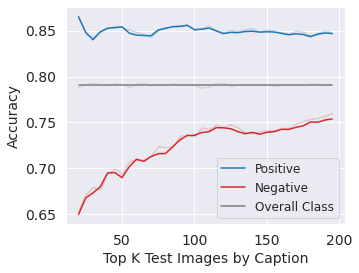

In [15]:
# import src.clip_utils as clip_utils
# cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])

# clip_analyzer = viz_utils.ClipAnalyzer(
#     processor=processor, svm_model_name=svm_model_name, caption_set_name="CIFARSIMPLE", class_names=cifar_label_list)

# def get_cdf(arr, K_range=None):
#     out = []
#     if K_range is None:
#         K_range = np.arange(10, len(arr), 10)
#     for K in K_range:
#         out.append(arr[:K].mean())
#     out = np.array(out)
#     return out, K_range

# saved_caption_and_most_relevant_imgs = {}
# all_dfs = []
# for target_class in range(10):
#     print(processor.metrics['cv_scores'][target_class])
#     print("performing classify captions on svm")
#     result = clip_analyzer.get_svm_style_top_K(target_class, 'all')
#     print("--------")

#     cdfs = {}
#     class_mask = test_class==target_class
#     masked_indices = np.arange(len(test_class))[class_mask]
#     # K_range = np.arange(10, len(masked_indices), 10)
#     K_range=np.arange(20, 200, 5)
#     for caption_index in range(1):
#         for direction in ['pos', 'neg']:
#             caption_text = result[f'{direction}_captions'][caption_index]
#             print(f"{direction}: {caption_text}")
#             top_caption_latent = torch.tensor(result[f'{direction}_latents'][caption_index]).cuda()

#             image_latents = clip_analyzer.clip_features['test'][class_mask].cuda()
#             image_angles = clip_utils.order_descriptions_angle(mean_point=top_caption_latent.unsqueeze(0), query_points=image_latents)
#             image_order = np.argsort(image_angles)[::-1]
#             saved_caption_and_most_relevant_imgs[(target_class, caption_index, direction)] = (masked_indices[image_order], caption_text)
#             dir_name = 'Positive' if direction == 'pos' else 'Negative' 
#             cdfs[dir_name], _ = get_cdf(test_correct[masked_indices[image_order]], K_range)
#             # uncomment this to display the images

#         df = pd.DataFrame()
#         df['Top K'] = K_range
#         for d, v in cdfs.items():
#             df[d] = v
#         df['Overall Class'] = test_correct[masked_indices].mean()
#         df = df.melt('Top K', var_name='Order', value_name='Accuracy')
#         all_dfs.append(df)
    
combined_df = pd.concat(all_dfs).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(5,4))
sns.lineplot(data=combined_df, x='Top K', y='Accuracy', hue='Order', ax=ax, 
             hue_order=['Positive', 'Negative', 'Overall Class'], 
            palette=[BLUE, RED, GRAY], ci=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
ax.set_xlabel("Top K Test Images by Caption")
plt.savefig("figures/cifarsimple.pdf", bbox_inches='tight')
plt.show()
    

In [7]:
flip_interventions = torch.load("/mnt/cfs/home/saachij/src/failure-directions/failure_directions/cifar_caption_level_imgs_2.pt")
rdir = "/mnt/cfs/home/saachij/src/failure-directions/failure_directions/sd_files/cifar10/caption_level_freeze"
base_name = 'cifar_caption_level_imgs_freeze'
flip_interventions_ = [
    torch.load(os.path.join(rdir, f"{base_name}_A.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_B.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_C.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_D.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_E.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_G.pt")),
    torch.load(os.path.join(rdir, f"{base_name}_H.pt")),
]

In [11]:
# mapping = {
#     'pos': 0,
#     'neg': 0.1,
#     'neutral': 0,
# }
mapping = {
    'pos': 'pos',
    'neg': 'neg',
    'neutral': 'neutral',
}
flip_interventions = {'pos': [], 'neg': [], 'neutral': []}
for f in flip_interventions_:
    for g in ['pos', 'neg', 'neutral']:
        for u in f[mapping[g]]:
            flip_interventions[g].append(u)

In [12]:

flip_int_corrects = {}
for k in flip_interventions:
    arr = flip_interventions[k]
    flip_int_corrects[k] = [arr[v][0] ==  arr[v][1] for v in range(len(arr))]

15


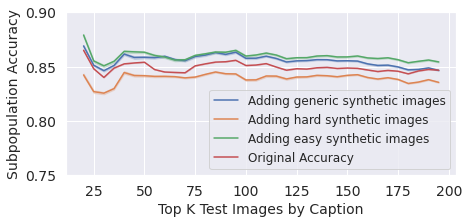

15


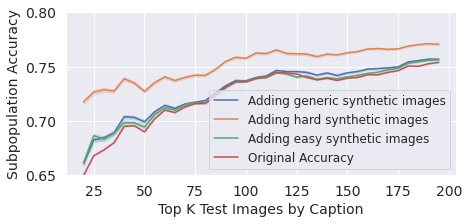

In [48]:
for POS_MODE in [True, False]:
    if POS_MODE:
        q_tag = 'pos'
    else:
        q_tag = 'neg'
    def get_dv_indices(target_c):
        dv = test_dv
        mask = test_class == target_c
        inds = np.arange(len(dv))[mask]
        return inds[np.argsort(dv[mask])]

    fig, ax_ = plt.subplots(1, 1, figsize=(7, 3))
    cls = -1
    trials = len(flip_int_corrects['pos'])
    print(trials)
    ax = ax_
    load_corrects = {
        'pos': flip_int_corrects['pos'],
        'neg': flip_int_corrects['neg'],
        'neutral': flip_int_corrects['neutral'],
        'baseline': [torch.tensor(test_correct == 1) for _ in range(trials)],

    }

    K = 100


    all_dfs = []
    # valid_classes = np.arange(10)
    if cls == -1:
        valid_classes = np.arange(10)
    else:
        valid_classes = [cls]
    for v in range(trials):
        xaxis = np.arange(20, 200, 5)
        accs = {k:[] for k in load_corrects.keys()}
        for K in xaxis:
    #         minority_indices = np.concatenate([get_dv_indices(target_c)[:K] for target_c in valid_classes])
            minority_indices = np.concatenate([saved_caption_and_most_relevant_imgs[(target_c, 0, q_tag)][0][:K] for target_c in valid_classes])
            for k in load_corrects.keys():
                accs[k].append(load_corrects[k][v][minority_indices].float().mean().item())
        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = accs['neutral']
        df['Adding hard synthetic images'] = accs['neg']
        df['Adding easy synthetic images'] = accs['pos']

        df['Original Accuracy'] = accs['baseline']
        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        all_dfs.append(df)


    all_df = pd.concat(all_dfs).reset_index()

    sns.lineplot(data=all_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    t = 'All' if cls == -1 else cifar_label_list[cls]  
    # ax.set_title(f'{t}')
    if POS_MODE:
        ax.set_ylim(0.75, 0.9)
    else:
        ax.set_ylim(0.65, 0.8)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc='lower right')
    if POS_MODE:
        plt.savefig('easy_finetune.pdf', bbox_inches='tight')
    else:
        plt.savefig('hard_finetune.pdf', bbox_inches='tight')
    plt.show()


In [19]:
for r in clip_analyzer.captions['reference']:
    print(r)
for c in range(10):
    print(saved_caption_and_most_relevant_imgs[(c, 0, 'neg')][1])

a photo of a airplane
a photo of a automobile
a photo of a bird
a photo of a cat
a photo of a deer
a photo of a dog
a photo of a frog
a photo of a horse
a photo of a ship
a photo of a truck
